# Multimodal entailment

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/08/08<br>
**Last modified:** 2021/08/15<br>
**Description:** Training a multimodal model for predicting entailment.

## Introduction

In this example, we will build and train a model for predicting multimodal entailment. We will be
using the
[multimodal entailment dataset](https://github.com/google-research-datasets/recognizing-multimodal-entailment)
recently introduced by Google Research.

### What is multimodal entailment?

On social media platforms, to audit and moderate content
we may want to find answers to the
following questions in near real-time:

* Does a given piece of information contradict the other?
* Does a given piece of information imply the other?

In NLP, this task is called analyzing _textual entailment_. However, that's only
when the information comes from text content.
In practice, it's often the case the information available comes not just
from text content, but from a multimodal combination of text, images, audio, video, etc.
_Multimodal entailment_ is simply the extension of textual entailment to a variety
of new input modalities.

### Requirements

This example requires TensorFlow 2.5 or higher. In addition, TensorFlow Hub and
TensorFlow Text are required for the BERT model
([Devlin et al.](https://arxiv.org/abs/1810.04805)). These libraries can be installed
using the following command:

In [1]:
!pip install -q tensorflow_text

In [1]:
import tensorflow as tf
print(tf. __version__)

2.8.0


## Imports

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

## Define a label map

In [3]:
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}

## Collect the dataset

The original dataset is available
[here](https://github.com/google-research-datasets/recognizing-multimodal-entailment).
It comes with URLs of images which are hosted on Twitter's photo storage system called
the
[Photo Blob Storage (PBS for short)](https://blog.twitter.com/engineering/en_us/a/2012/blobstore-twitter-s-in-house-photo-storage-system).
We will be working with the downloaded images along with additional data that comes with
the original dataset. Thanks to
[Nilabhra Roy Chowdhury](https://de.linkedin.com/in/nilabhraroychowdhury) who worked on
preparing the image data.

In [4]:
image_base_path = keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

## Read the dataset and apply basic preprocessing

In [5]:
df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)
df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label
502,1340073003980242944,"Dec. 18, 2020 COVID-19 Update: 130 New Cases (...",http://pbs.twimg.com/media/EpjlS9DUwAAB6_g.jpg,1346994231815016448,"Jan. 6, 2021 COVID-19 Update: 143 New Cases (8...",http://pbs.twimg.com/media/ErF8HbwVgAIi56l.jpg,NoEntailment
898,1344186326728507392,M1.4 #earthquake (#potres) strikes 26 km S of ...,http://pbs.twimg.com/media/EqeBItLXIAEktJe.png,1344358109838499840,M1.2 #earthquake (#potres) strikes 28 km S of ...,http://pbs.twimg.com/media/Eqgek3MXIAYHtW7.png,NoEntailment
706,1353901921094930432,Wishing everyone Happy 72nd Republic Day!!🇮🇳🇮🇳...,http://pbs.twimg.com/media/EsoGnVhW4AIlukO.jpg,1353932453589692416,"Freedom in the mind, strength in the words, pu...",http://pbs.twimg.com/media/EsoiYpeW4AATibt.jpg,NoEntailment
1031,1379705813351211011,"Acknowledge the fear, and do it anyway!\n\n#Ch...",http://pbs.twimg.com/media/EyWzIEXWgAMVNiv.png,1382242448265650176,Fear does not equal failure. Keep moving forw...,http://pbs.twimg.com/media/Ey62LoOXAAAw4z6.png,NoEntailment
600,1378322302950051842,Here are the nominees for Best Hiphop song of ...,http://pbs.twimg.com/media/EyDD5K2WUAM-Erg.jpg,1378397905489383424,These are your nominees for Best Hiplife Song ...,http://pbs.twimg.com/media/EyC3aIHXAAIFH9a.jpg,NoEntailment
376,1379825237093720066,On 07/04/21 at 05:45 the river level was 31.23...,http://pbs.twimg.com/media/EyYfvTcXIAIn68G.png,1379882083896676355,On 07/04/21 at 09:45 the river level was 0.27m...,http://pbs.twimg.com/media/EyZTcOBWgAIfOkZ.png,NoEntailment
970,1345058844439949312,Participants needed for online survey!\n\nTopi...,http://pbs.twimg.com/media/Eqqb4_MXcAA-Pvu.jpg,1361211461792632835,Participants needed for top-ranked study on Su...,http://pbs.twimg.com/media/EuPz0GwXMAMDklt.jpg,NoEntailment
996,1340340513925439495,VIDEO: Holiday how-to - Make perfect gravy for...,http://pbs.twimg.com/media/EpnYmACXUAEIrjI.jpg,1340465985158074368,VIDEO: Holiday how-to - Make perfect gravy for...,http://pbs.twimg.com/media/EppKtY8XUA4A303.jpg,NoEntailment
304,1381817348055724035,Updated lineup for tonight's game: https://t.c...,http://pbs.twimg.com/media/Eyz2EqxVgAACUQW.jpg,1383825087653023745,#IUBase lineup vs. Northwestern today at 1 PM....,http://pbs.twimg.com/media/EzRCriYVIAU5D8g.jpg,NoEntailment
189,1359464643236888576,Daily Chess Training: \nVidit-Carlsen\nOpera ...,http://pbs.twimg.com/media/Et3J44AXAAUgneo.png,1378037110259785734,Daily Chess Training:\nM.Bartel-Artemiev\nEuro...,http://pbs.twimg.com/media/Ex_FcvvWEAE2sOP.png,NoEntailment


The columns we are interested in are the following:

* `text_1`
* `image_1`
* `text_2`
* `image_2`
* `label`

The entailment task is formulated as the following:

***Given the pairs of (`text_1`, `image_1`) and (`text_2`, `image_2`) do they entail (or
not entail or contradict) each other?***

We have the images already downloaded. `image_1` is downloaded as `id1` as its filename
and `image2` is downloaded as `id2` as its filename. In the next step, we will add two
more columns to `df` - filepaths of `image_1`s and `image_2`s.

In [6]:
images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1]
    extentsion_two = current_row["image_2"].split(".")[-1]

    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

# Create another column containing the integer ids of
# the string labels.
df["label_idx"] = df["label"].apply(lambda x: label_map[x])

## Dataset visualization

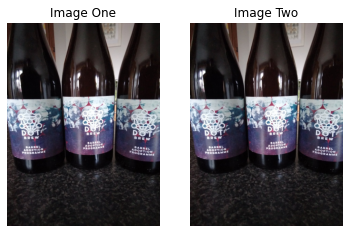

Text one: More @DOT_Brew Barrel Adoption #CraftBeer can't wait to delve in cheers 😋🍺 https://t.co/W5XDudFiTP
Text two: Last one of the barrel adoption programme 2020 and what a journey of #craftbeer the @DOT_Brew have given me and this is no different a v tasty #stout at 10.5% #drinkirish #supportcraftbeer 👏👏👌🍻 https://t.co/uDABTqJrzb
Label: NoEntailment


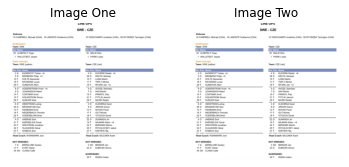

Text one: Lineups 🇸🇪 vs 🇨🇿
#worldjuniors https://t.co/jzsD8YzM5J
Text two: Line-ups for the semi-final between Canada and Russia! #WorldJuniors @FullPressNHL https://t.co/alOEPPZIzY
Label: NoEntailment


In [7]:

def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print(f"Text two: {text_2}")
    print(f"Label: {label}")


random_idx = np.random.choice(len(df))
visualize(random_idx)

random_idx = np.random.choice(len(df))
visualize(random_idx)

## Train/test split

The dataset suffers from
[class imbalance problem](https://developers.google.com/machine-learning/glossary#class-imbalanced-dataset).
We can confirm that in the following cell.

In [8]:
df["label"].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

To account for that we will go for a stratified split.

In [9]:
# 10% for test
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["label"].values, random_state=42
)
# 5% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["label"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1197
Total validation examples: 63
Total test examples: 140


## Data input pipeline

TensorFlow Hub provides
[variety of BERT family of models](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub).
Each of those models comes with a
corresponding preprocessing layer. You can learn more about these models and their
preprocessing layers from
[this resource](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub).

To keep the runtime of this example relatively short, we will use a smaller variant of
the original BERT model.

In [10]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

Our text preprocessing code mostly comes from
[this tutorial](https://www.tensorflow.org/text/tutorials/bert_glue).
You are highly encouraged to check out the tutorial to learn more about the input
preprocessing.

In [11]:
seq_length=128
dict(seq_length=seq_length)

{'seq_length': 128}

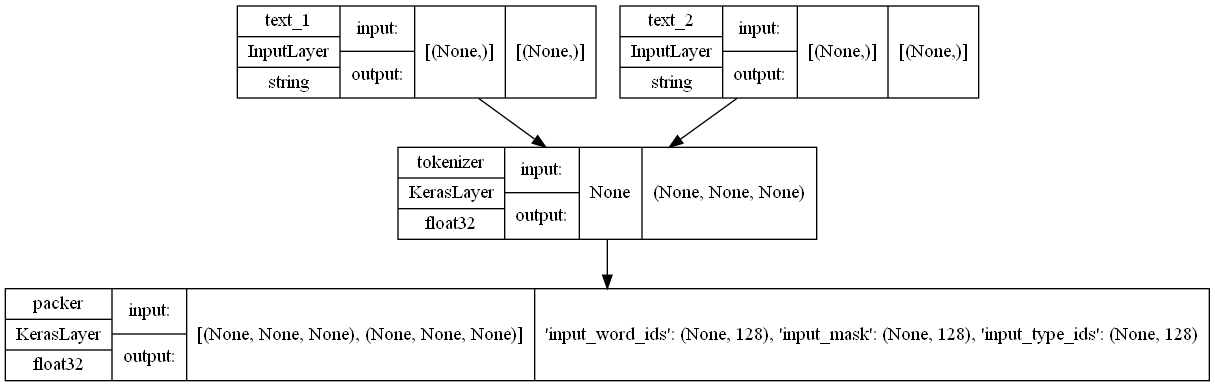

In [12]:

def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocessing_model(["text_1", "text_2"])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

### Run the preprocessor on a sample input

In [ ]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

# test_text = [np.array([sample_text_1]), np.array([sample_text_2])]
# text_preprocessed = bert_preprocess_model(test_text)

# print("Keys           : ", list(text_preprocessed.keys()))
# print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
# print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
# print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
# print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
# print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
# print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: BCBtigers: WICKET! Abu Jayed gets another, Warrican gone for 2. West Indies are 398/9 in 139.2 overs. 

#BANvWI #RiseOfTheTigers https://t.co/JaUYh1FvNY
Text 2: WICKET! Fourth in the innings for Taijul, Joseph gone for 9. West Indies are 114/8 in 51.2 overs, lead by 227 runs.

#BANvWI #RiseOfTheTigers https://t.co/bsGaGI13KC


We will now create `tf.data.Dataset` objects from the dataframes.

Note that the text inputs will be preprocessed as a part of the data input pipeline. But
the preprocessing modules can also be a part of their corresponding BERT models. This
helps reduce the training/serving skew and lets our models operate with raw text inputs.
Follow [this tutorial](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)
to learn more about how to incorporate the preprocessing modules directly inside the
models.

In [13]:

def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


### Preprocessing utilities

In [14]:
resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.io.decode_jpeg(image, 3)
    else:
        image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["image_1_path"])
    image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}


### Create the final datasets

In [15]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)


## Model building utilities

Our final model will accept two images along with their text counterparts. While the
images will be directly fed to the model the text inputs will first be preprocessed and
then will make it into the model. Below is a visual illustration of this approach:

![](https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/figures/brief_architecture.png)

The model consists of the following elements:

* A standalone encoder for the images. We will use a
[ResNet50V2](https://arxiv.org/abs/1603.05027) pre-trained on the ImageNet-1k dataset for
this.
* A standalone encoder for the images. A pre-trained BERT will be used for this.

After extracting the individual embeddings, they will be projected in an identical space.
Finally, their projections will be concatenated and be fed to the final classification
layer.

This is a multi-class classification problem involving the following classes:

* NoEntailment
* Implies
* Contradictory

`project_embeddings()`, `create_vision_encoder()`, and `create_text_encoder()` utilities
are referred from [this example](https://keras.io/examples/nlp/nl_image_search/).

Projection utilities

In [16]:
# The project_embeddings is used to transform the image and the text embeddings
# to the same embedding space with the same dimensionality.
# LayerNormalization Normalize the activations of the previous layer for each given example in a batch independently, rather than across a batch like Batch Normalization. 
# i.e. applies a transformation that maintains the mean activation within each example close to 0 and the activation standard deviation close to 1.
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


Vision encoder utilities

In [17]:

def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")


Text encoder utilities

In [18]:

def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")


Multimodal model utilities

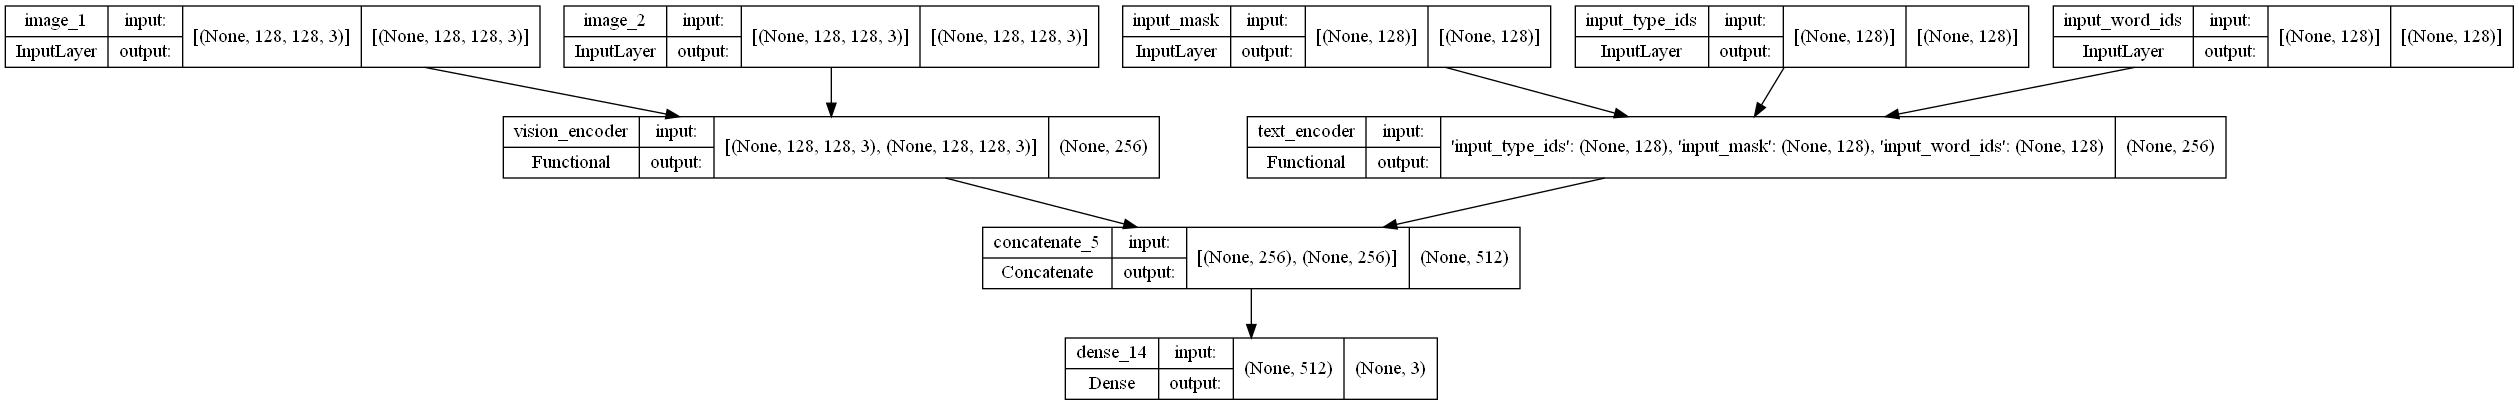

In [21]:

def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

You can inspect the structure of the individual encoders as well by setting the
`expand_nested` argument of `plot_model()` to `True`. You are encouraged
to play with the different hyperparameters involved in building this model and
observe how the final performance is affected.

## Compile and train the model

In [22]:
multimodal_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10
38/38 [==============================] - 26s 414ms/step - loss: 0.9268 - accuracy: 0.8446 - val_loss: 0.6611 - val_accuracy: 0.8254
Epoch 2/10
38/38 [==============================] - 3s 85ms/step - loss: 0.4020 - accuracy: 0.8872 - val_loss: 0.6446 - val_accuracy: 0.8095
Epoch 3/10
38/38 [==============================] - 3s 86ms/step - loss: 0.3350 - accuracy: 0.8939 - val_loss: 0.6220 - val_accuracy: 0.7937
Epoch 4/10
38/38 [==============================] - 3s 86ms/step - loss: 0.2377 - accuracy: 0.9240 - val_loss: 0.6752 - val_accuracy: 0.7619
Epoch 5/10
38/38 [==============================] - 3s 86ms/step - loss: 0.1434 - accuracy: 0.9541 - val_loss: 1.0552 - val_accuracy: 0.8095
Epoch 6/10
38/38 [==============================] - 3s 87ms/step - loss: 0.1546 - accuracy: 0.9532 - val_loss: 1.2193 - val_accuracy: 0.7937
Epoch 7/10
38/38 [==============================] - 3s 87ms/step - loss: 0.1752 - accuracy: 0.9432 - val_loss: 1.2777 - val_accuracy: 0.6032
Epoch 8/10


## Evaluate the model

In [23]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 3s 415ms/step - loss: 1.1671 - accuracy: 0.8786
Accuracy on the test set: 87.86%.


## Additional notes regarding training

**Incorporating regularization**:

The training logs suggest that the model is starting to overfit and may have benefitted
from regularization. Dropout ([Srivastava et al.](https://jmlr.org/papers/v15/srivastava14a.html))
is a simple yet powerful regularization technique that we can use in our model.
But how should we apply it here?

We could always introduce Dropout (`keras.layers.Dropout`) in between different layers of the model.
But here is another recipe. Our model expects inputs from two different data modalities.
What if either of the modalities is not present during inference? To account for this,
we can introduce Dropout to the individual projections just before they get concatenated:

```python
vision_projections = keras.layers.Dropout(rate)(vision_projections)
text_projections = keras.layers.Dropout(rate)(text_projections)
concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
```

**Attending to what matters**:

Do all parts of the images correspond equally to their textual counterparts? It's likely
not the case. To make our model only focus on the most important bits of the images that relate
well to their corresponding textual parts we can use "cross-attention":

```python
# Embeddings.
vision_projections = vision_encoder([image_1, image_2])
text_projections = text_encoder(text_inputs)

# Cross-attention (Luong-style).
query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)(
    [vision_projections, text_projections]
)
# Concatenate.
concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
contextual = keras.layers.Concatenate()([concatenated, query_value_attention_seq])
```

To see this in action, refer to
[this notebook](https://github.com/sayakpaul/Multimodal-Entailment-Baseline/blob/main/multimodal_entailment_attn.ipynb).

**Handling class imbalance**:

The dataset suffers from class imbalance. Investigating the confusion matrix of the
above model reveals that it performs poorly on the minority classes. If we had used a
weighted loss then the training would have been more guided. You can check out
[this notebook](https://github.com/sayakpaul/Multimodal-Entailment-Baseline/blob/main/multimodal_entailment.ipynb)
that takes class-imbalance into account during model training.

**Using only text inputs**:

Also, what if we had only incorporated text inputs for the entailment task? Because of
the nature of the text inputs encountered on social media platforms, text inputs alone
would have hurt the final performance. Under a similar training setup, by only using
text inputs we get to 67.14% top-1 accuracy on the same test set. Refer to
[this notebook](https://github.com/sayakpaul/Multimodal-Entailment-Baseline/blob/main/text_entailment.ipynb)
for details.

Finally, here is a table comparing different approaches taken for the entailment task:

| Type  | Standard<br>Cross-entropy     | Loss-weighted<br>Cross-entropy    | Focal Loss    |
|:---:  |:---:  |:---:    |:---:    |
| Multimodal    | 77.86%    | 67.86%    | 86.43%    |
| Only text     | 67.14%    | 11.43%    | 37.86%    |

You can check out [this repository](https://git.io/JR0HU) to learn more about how the
experiments were conducted to obtain these numbers.

## Final remarks

* The architecture we used in this example is too large for the number of data points
available for training. It's going to benefit from more data.
* We used a smaller variant of the original BERT model. Chances are high that with a
larger variant, this performance will be improved. TensorFlow Hub
[provides](https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub)
a number of different BERT models that you can experiment with.
* We kept the pre-trained models frozen. Fine-tuning them on the multimodal entailment
task would could resulted in better performance.
* We built a simple baseline model for the multimodal entailment task. There are various
approaches that have been proposed to tackle the entailment problem.
[This presentation deck](https://docs.google.com/presentation/d/1mAB31BCmqzfedreNZYn4hsKPFmgHA9Kxz219DzyRY3c/edit?usp=sharing)
from the
[Recognizing Multimodal Entailment](https://multimodal-entailment.github.io/)
tutorial provides a comprehensive overview.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/multimodal-entailment) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/multimodal_entailment)